In [1]:
# Environment setup and imports
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import yaml
from typing import List, Dict

ROOT = Path().resolve().parents[2]  # project root
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data.real_data import CriteoDataset, SyntheticCriteoDataset, PCBDataset
from src.models.esmm import ESMM
from src.models.gbdt_proto import MTGBDT
from src.models.stgbdt import STGBDTBaseline
from src.models.utils import add_cvr_labels


def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Compute CTR/CTCVR/CVR AUC and LogLoss."""
    eps = 1e-8
    y_click = y_true[:, 0]
    y_conv = y_true[:, 1]
    y_ctcvr = y_click * y_conv

    pred_ctr = np.clip(y_pred[:, 0], eps, 1 - eps)
    pred_ctcvr = np.clip(y_pred[:, 1], eps, 1 - eps)
    pred_cvr = np.clip(y_pred[:, 2], eps, 1 - eps)

    metrics = {}
    metrics["auc_ctr"] = roc_auc_score(y_click, pred_ctr)
    metrics["logloss_ctr"] = log_loss(y_click, pred_ctr)
    precision, recall, thresholds = precision_recall_curve(y_click, pred_ctr)
    metrics["pr_auc_ctr"] = auc(recall, precision)

    metrics["auc_ctcvr"] = roc_auc_score(y_ctcvr, pred_ctcvr)
    metrics["logloss_ctcvr"] = log_loss(y_ctcvr, pred_ctcvr)
    precision, recall, thresholds = precision_recall_curve(y_ctcvr, pred_ctcvr)
    metrics["pr_auc_ctcvr"] = auc(recall, precision)

    click_mask = y_click == 1
    if np.sum(click_mask) > 1 and np.unique(y_conv[click_mask]).size > 1:
        metrics["auc_cvr"] = roc_auc_score(y_conv[click_mask], pred_cvr[click_mask])
        metrics["logloss_cvr"] = log_loss(y_conv[click_mask], pred_cvr[click_mask])
        precision, recall, thresholds = precision_recall_curve(y_conv[click_mask], pred_cvr[click_mask])
        metrics["pr_auc_cvr"] = auc(recall, precision)
    else:
        metrics["auc_cvr"] = np.nan
        metrics["logloss_cvr"] = np.nan
    return metrics

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
# Configure paths and parameter
def get_data(train_size: int, test_size: int, val_size: int, data_type: str):
    sample_size = train_size + test_size + val_size
    seed = 42
    output_csv = ROOT / "reports" / "tables" / "criteo_experiment_notebook.csv"
    results = []

    if data_type == "criteo":
        # Load Criteo or Synthetic dataset
        data_path = ROOT / "src" / "data" / "criteo-research-uplift-v2.1.csv.gz"
        dataset = CriteoDataset(sample_size=sample_size)
        try:
            X, y = dataset.get_data(random_state=seed)
            source = "CriteoDataset"
        except Exception:
            synth = SyntheticCriteoDataset(sample_size=sample_size)
            X, y = synth.load_data(random_state=seed)
            source = "SyntheticCriteoDataset"

    elif data_type == "PCB":
        # Load Criteo or Synthetic dataset
        # data_path = ROOT / "src" / "data" / "pcb_dataset_final.tsv.zip"
        dataset = PCBDataset(sample_size=sample_size)
        X, y = dataset.get_data(random_state=seed)
        source = "PCBDataset"

    print(f"Using dataset from {source} with {X.shape[0]} samples and {X.shape[1]} features.")
    # Random permutation without overlap
    rng = np.random.default_rng(seed)
    perm = rng.permutation(X.shape[0])
    if len(perm) < sample_size:
        raise ValueError(f"Requested {sample_size} samples but only {len(perm)} available")

    train_idx = perm[:train_size]
    val_idx = perm[train_size:train_size + val_size]
    test_idx = perm[train_size + val_size:train_size + val_size + test_size]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [2]:
# Configure paths and parameter
def get_data_pcb(train_size: int, test_size: int, val_size: int, seed: str):
    sample_size = train_size + test_size + val_size

    # Load Criteo or Synthetic dataset
    # data_path = ROOT / "src" / "data" / "pcb_dataset_final.tsv.zip"
    dataset = PCBDataset(sample_size=sample_size)
    X, y = dataset.get_data(random_state=seed)
    source = "PCBDataset"

    print(f"Using dataset from {source} with {X.shape[0]} samples and {X.shape[1]} features.")
    # Random permutation without overlap
    rng = np.random.default_rng(seed)
    perm = rng.permutation(X.shape[0])
    if len(perm) < sample_size:
        raise ValueError(f"Requested {sample_size} samples but only {len(perm)} available")

    train_idx = perm[:train_size]
    val_idx = perm[train_size:train_size + val_size]
    test_idx = perm[train_size + val_size:train_size + val_size + test_size]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [3]:
train_size=100000
val_size=30000
test_size=100000

X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size, data_type="PCB")
results = []

Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv


In [3]:
def do_esmm(X_train, X_val, X_test, y_train, y_val, y_test, results):
    # ESMM
    esmm = ESMM(epochs=5, batch_size=256, verbose=0, validation_split=0.0)
    esmm.fit(X_train, y_train)
    esmm_pred = esmm.predict_proba(X_test)
    esmm_metrics = evaluate_predictions(y_test, esmm_pred)
    esmm_metrics.update({"model": "ESMM", "train_size": train_size})
    esmm_metrics
    results.append(esmm_metrics)

def do_mtgbm(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="mtgbm"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "mtgbm", "train_size": train_size})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.01):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="ctcvr_subctr_de_norm_gain"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": f"propose_{delta}", "train_size": train_size})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_propose_kai(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="propose_kai"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "propose_kai", "n_estimators": mtgbdt.n_estimators})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_stgbdt(X_train, X_val, X_test, y_train, y_val, y_test, results):
    # STGBDT
    stg = STGBDTBaseline(
        n_estimators=20, learning_rate=0.1, max_depth=3, min_samples_split=20, min_samples_leaf=10
    )
    stg.fit(X_train, y_train)
    stg_pred = stg.predict_proba(X_test)
    stg_metrics = evaluate_predictions(y_test, stg_pred)
    stg_metrics.update({"model": "STGBDTBaseline", "train_size": train_size})
    stg_metrics
    results.append(stg_metrics)

def do_propose_half(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="half"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "propose_half", "n_estimators": mtgbdt.n_estimators})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

単回 / 複数回

In [ ]:
# results = []
for train_size in [10000, 50000, 100000]:
    for seed in range(42, 47):
        val_size=0
        test_size=100000
        X_train, X_val, X_test, y_train, y_val, y_test = get_data_pcb(train_size=train_size, val_size=val_size, test_size=test_size, seed=seed)
        do_esmm(X_train, X_val, X_test, y_train, y_val, y_test, results)
        do_mtgbm(X_train, X_val, X_test, y_train, y_val, y_test, results)
        # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.01)
        # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.5)
        do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=1)
        # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=5)
        # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=10)
        do_propose_kai(X_train, X_val, X_test, y_train, y_val, y_test, results)
        do_stgbdt(X_train, X_val, X_test, y_train, y_val, y_test, results)

Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv
Using dataset from PCBDataset with 110000 samples and 15 features.


c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.380434, Time: 0.34s
Iteration 10/20, LogLoss: 0.336468, Time: 3.60s
Iteration 20/20, LogLoss: 0.321781, Time: 7.15s
Iteration 1/20, LogLoss: 0.381976, Time: 0.32s
Iteration 10/20, LogLoss: 0.329243, Time: 3.35s
Iteration 20/20, LogLoss: 0.311852, Time: 6.82s
Iteration 1/20, LogLoss: 0.380431, Time: 0.61s
Iteration 10/20, LogLoss: 0.328123, Time: 7.36s
Iteration 20/20, LogLoss: 0.309892, Time: 13.77s
Iteration 1/20, LogLoss: 0.635796, Time: 0.37s
Iteration 10/20, LogLoss: 0.591624, Time: 6.28s
Iteration 20/20, LogLoss: 0.580247, Time: 13.02s
Iteration 1/20, LogLoss: 0.137018, Time: 0.62s
Iteration 10/20, LogLoss: 0.099228, Time: 4.27s
Iteration 20/20, LogLoss: 0.090268, Time: 8.17s
Iteration 1/20, LogLoss: 0.337623, Time: 0.13s
Iteration 10/20, LogLoss: 0.218980, Time: 1.85s
Iteration 20/20, LogLoss: 0.192905, Time: 3.21s
Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv
Using dataset from P

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.390861, Time: 0.34s
Iteration 10/20, LogLoss: 0.333122, Time: 3.53s
Iteration 20/20, LogLoss: 0.316845, Time: 6.90s
Iteration 1/20, LogLoss: 0.392420, Time: 0.32s
Iteration 10/20, LogLoss: 0.329540, Time: 3.21s
Iteration 20/20, LogLoss: 0.308791, Time: 6.32s
Iteration 1/20, LogLoss: 0.390433, Time: 0.49s
Iteration 10/20, LogLoss: 0.327362, Time: 5.69s
Iteration 20/20, LogLoss: 0.307546, Time: 10.88s
Iteration 1/20, LogLoss: 0.637422, Time: 0.33s
Iteration 10/20, LogLoss: 0.586069, Time: 3.39s
Iteration 20/20, LogLoss: 0.573835, Time: 6.67s
Iteration 1/20, LogLoss: 0.151449, Time: 0.37s
Iteration 10/20, LogLoss: 0.101211, Time: 3.33s
Iteration 20/20, LogLoss: 0.089186, Time: 6.57s
Iteration 1/20, LogLoss: 0.363556, Time: 0.13s
Iteration 10/20, LogLoss: 0.223588, Time: 1.24s
Iteration 20/20, LogLoss: 0.191642, Time: 2.52s
Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv
Using dataset from PC

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.384533, Time: 0.52s
Iteration 10/20, LogLoss: 0.341849, Time: 5.98s
Iteration 20/20, LogLoss: 0.328036, Time: 10.95s
Iteration 1/20, LogLoss: 0.385571, Time: 0.36s
Iteration 10/20, LogLoss: 0.330842, Time: 3.85s
Iteration 20/20, LogLoss: 0.313249, Time: 7.68s
Iteration 1/20, LogLoss: 0.384533, Time: 0.73s
Iteration 10/20, LogLoss: 0.330515, Time: 5.95s
Iteration 20/20, LogLoss: 0.311308, Time: 11.08s
Iteration 1/20, LogLoss: 0.637442, Time: 0.37s
Iteration 10/20, LogLoss: 0.593803, Time: 4.93s
Iteration 20/20, LogLoss: 0.582914, Time: 11.14s
Iteration 1/20, LogLoss: 0.142415, Time: 0.71s
Iteration 10/20, LogLoss: 0.102608, Time: 5.38s
Iteration 20/20, LogLoss: 0.092812, Time: 10.30s
Iteration 1/20, LogLoss: 0.346130, Time: 0.12s
Iteration 10/20, LogLoss: 0.225799, Time: 1.23s
Iteration 20/20, LogLoss: 0.198714, Time: 2.90s
Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv
Using dataset from

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.384362, Time: 0.67s
Iteration 10/20, LogLoss: 0.338300, Time: 5.47s
Iteration 20/20, LogLoss: 0.324269, Time: 10.39s
Iteration 1/20, LogLoss: 0.384473, Time: 0.34s
Iteration 10/20, LogLoss: 0.332712, Time: 3.75s
Iteration 20/20, LogLoss: 0.316637, Time: 8.14s
Iteration 1/20, LogLoss: 0.384016, Time: 0.74s
Iteration 10/20, LogLoss: 0.331970, Time: 8.86s
Iteration 20/20, LogLoss: 0.313807, Time: 17.45s
Iteration 1/20, LogLoss: 0.632246, Time: 0.65s
Iteration 10/20, LogLoss: 0.584946, Time: 6.09s
Iteration 20/20, LogLoss: 0.573387, Time: 11.26s
Iteration 1/20, LogLoss: 0.144558, Time: 0.42s
Iteration 10/20, LogLoss: 0.106525, Time: 3.55s
Iteration 20/20, LogLoss: 0.097249, Time: 7.81s
Iteration 1/20, LogLoss: 0.352798, Time: 0.15s
Iteration 10/20, LogLoss: 0.237470, Time: 1.80s
Iteration 20/20, LogLoss: 0.211843, Time: 4.28s
Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv
Using dataset from 

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.382732, Time: 0.33s
Iteration 10/20, LogLoss: 0.335116, Time: 3.57s
Iteration 20/20, LogLoss: 0.322114, Time: 6.97s
Iteration 1/20, LogLoss: 0.383392, Time: 0.52s
Iteration 10/20, LogLoss: 0.333147, Time: 4.16s
Iteration 20/20, LogLoss: 0.316332, Time: 7.53s
Iteration 1/20, LogLoss: 0.382732, Time: 1.07s
Iteration 10/20, LogLoss: 0.331956, Time: 7.21s
Iteration 20/20, LogLoss: 0.313961, Time: 15.89s
Iteration 1/20, LogLoss: 0.630407, Time: 0.62s
Iteration 10/20, LogLoss: 0.584375, Time: 5.37s
Iteration 20/20, LogLoss: 0.573327, Time: 11.28s
Iteration 1/20, LogLoss: 0.142726, Time: 0.68s
Iteration 10/20, LogLoss: 0.105566, Time: 5.67s
Iteration 20/20, LogLoss: 0.096643, Time: 10.67s
Iteration 1/20, LogLoss: 0.352962, Time: 0.23s
Iteration 10/20, LogLoss: 0.238551, Time: 2.14s
Iteration 20/20, LogLoss: 0.213372, Time: 4.18s
Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv
Using dataset from 

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.384677, Time: 1.83s
Iteration 10/20, LogLoss: 0.340580, Time: 17.92s
Iteration 20/20, LogLoss: 0.325200, Time: 37.13s
Iteration 1/20, LogLoss: 0.384610, Time: 1.57s
Iteration 10/20, LogLoss: 0.333997, Time: 14.30s
Iteration 20/20, LogLoss: 0.316405, Time: 28.46s
Iteration 1/20, LogLoss: 0.384627, Time: 1.94s


In [ ]:
results = []
for train_size in [10000, 50000, 100000]:
    val_size=0
    test_size=100000
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size, data_type="PCB")
    do_esmm(X_train, X_val, X_test, y_train, y_val, y_test, results)
    do_mtgbm(X_train, X_val, X_test, y_train, y_val, y_test, results)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.01)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.1)
    do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=1)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=5)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=10)
    do_propose_kai(X_train, X_val, X_test, y_train, y_val, y_test, results)
    do_stgbdt(X_train, X_val, X_test, y_train, y_val, y_test, results)

In [9]:
for train_size in [10000, 50000]:
    val_size=int(train_size * 0.5)
    test_size=100000
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size)
    do_propose_half(X_train, X_val, X_test, y_train, y_val, y_test, results)

Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 115000 samples with 16 columns
Data shape: X=(115000, 12), y=(115000, 2)
Iteration 1/20, LogLoss: 0.063840, Time: 0.21s
Iteration 10/20, LogLoss: 0.049750, Time: 2.04s
Iteration 20/20, LogLoss: 0.046199, Time: 4.02s
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 175000 samples with 16 columns
Data shape: X=(175000, 12), y=(175000, 2)
Iteration 1/20, LogLoss: 0.061754, Time: 0.97s
Iteration 10/20, LogLoss: 0.049574, Time: 9.67s
Iteration 20/20, LogLoss: 0.046667, Time: 25.68s


In [10]:
df_results = pd.read_csv("C:\\Users\\oiwal\\products\\MT_AI_GBDT\\src\\data\\criteo_bid_eval.csv.csv")
df_results


,auc_ctr,logloss_ctr,pr_auc_ctr,auc_ctcvr,logloss_ctcvr,pr_auc_ctcvr,auc_cvr,logloss_cvr,pr_auc_cvr,model,train_size,n_estimators
0,0.577531,2.091291,0.476889,0.838643,0.303534,0.644352,0.880472,0.646229,0.769116,ESMM,10000.0,NaN
1,0.699565,0.577447,0.603989,0.880742,0.101622,0.684409,0.837036,0.236274,0.729224,mtgbm,10000.0,NaN
2,0.708759,0.578924,0.602670,0.913457,0.094409,0.714014,0.892702,0.211860,0.786845,propose_0.01,10000.0,NaN
3,0.708759,0.578924,0.602670,0.913457,0.094409,0.714014,0.892702,0.211860,0.786845,propose_1,10000.0,NaN
4,0.708759,0.578924,0.602670,0.913457,0.094409,0.714014,0.892702,0.211860,0.786845,propose_10,10000.0,NaN
5,0.720951,0.571884,0.610050,0.913443,0.095545,0.713587,0.893773,0.215562,0.787445,propose_kai,NaN,20.0
6,0.699918,0.577620,0.602449,0.850361,0.100929,0.687624,0.848591,0.214418,0.801506,STGBDTBaseline,10000.0,NaN
7,0.575866,1.841625,0.483457,0.858875,0.265477,0.676407,0.899114,0.601349,0.793741,ESMM,50000.0,NaN
8,0.699185,0.576118,0.622602,0.880626,0.101351,0.719924,0.835717,0.235035,0.751970,mtgbm,50000.0,NaN
9,0.713832,0.575551,0.605948,0.919425,0.093432,0.724800,0.902718,0.209090,0.802717,propose_0.01,50000.0,NaN


In [8]:
# Aggregate and display metrics
headers = ["model", "auc_ctr", "auc_ctcvr", "auc_cvr", "logloss_ctr", "logloss_ctcvr", "logloss_cvr"]
print("\n=== Experiment Results ===")
for res in results:
    row = {h: res.get(h, np.nan) for h in headers}
    print(row)

df_results = pd.DataFrame(results)
df_results


=== Experiment Results ===
{'model': 'ESMM', 'auc_ctr': 0.5699474825388258, 'auc_ctcvr': 0.8633861853951117, 'auc_cvr': 0.9058287245758585, 'logloss_ctr': 2.039940848018226, 'logloss_ctcvr': 0.25460025584297674, 'logloss_cvr': 0.44393522617553133}
{'model': 'mtgbm', 'auc_ctr': 0.6991888740250265, 'auc_ctcvr': 0.880741246128646, 'auc_cvr': 0.8374057824602034, 'logloss_ctr': 0.575320790534808, 'logloss_ctcvr': 0.10173534260804994, 'logloss_cvr': 0.23586969397284968}
{'model': 'propose_0.01', 'auc_ctr': 0.7149857812965484, 'auc_ctcvr': 0.9168233159703407, 'auc_cvr': 0.9002090385109074, 'logloss_ctr': 0.5758566936124269, 'logloss_ctcvr': 0.09412202373505096, 'logloss_cvr': 0.2097290042740996}
{'model': 'propose_1', 'auc_ctr': 0.7149857812965484, 'auc_ctcvr': 0.9168233159703407, 'auc_cvr': 0.9002090385109074, 'logloss_ctr': 0.5758566936124269, 'logloss_ctcvr': 0.09412202373505096, 'logloss_cvr': 0.2097290042740996}
{'model': 'propose_10', 'auc_ctr': 0.7149857812965484, 'auc_ctcvr': 0.91682

,auc_ctr,logloss_ctr,pr_auc_ctr,auc_ctcvr,logloss_ctcvr,pr_auc_ctcvr,auc_cvr,logloss_cvr,pr_auc_cvr,model,train_size,n_estimators
0,0.569947,2.039941,0.481452,0.863386,0.254600,0.678547,0.905829,0.443935,0.809506,ESMM,100000.0,NaN
1,0.699189,0.575321,0.612129,0.880741,0.101735,0.705129,0.837406,0.235870,0.744247,mtgbm,100000.0,NaN
2,0.714986,0.575857,0.607194,0.916823,0.094122,0.723841,0.900209,0.209729,0.802260,propose_0.01,100000.0,NaN
3,0.714986,0.575857,0.607194,0.916823,0.094122,0.723841,0.900209,0.209729,0.802260,propose_1,100000.0,NaN
4,0.714986,0.575857,0.607194,0.916823,0.094122,0.723841,0.900209,0.209729,0.802260,propose_10,100000.0,NaN
5,0.720220,0.574938,0.608970,0.917281,0.094213,0.722853,0.899647,0.210931,0.799254,propose_kai,NaN,20.0
6,0.699189,0.575321,0.612129,0.882964,0.098072,0.705199,0.849648,0.215613,0.803802,STGBDTBaseline,100000.0,NaN


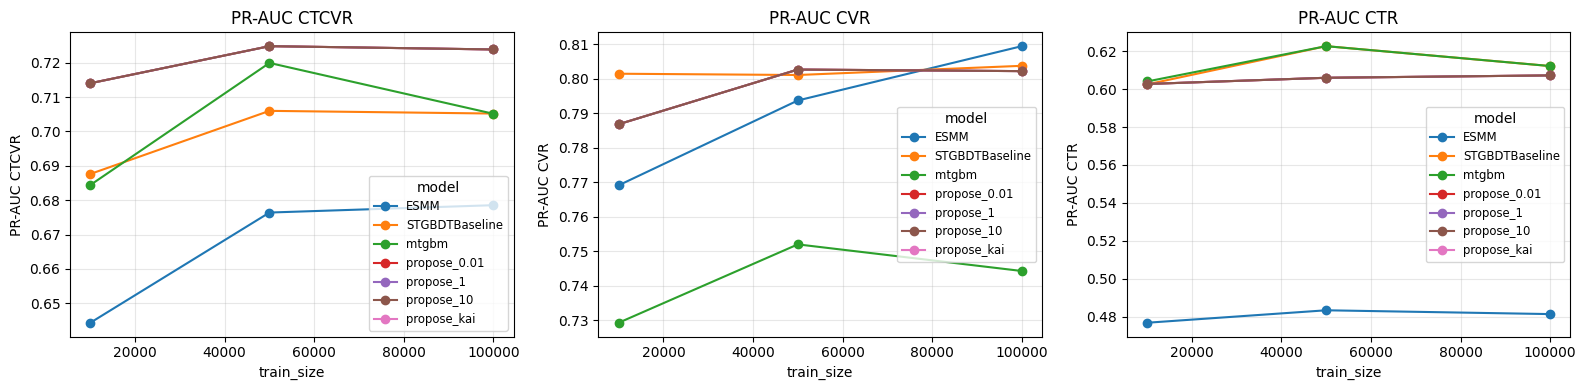

In [11]:
# PR-AUC curves per model vs train_size
import matplotlib.pyplot as plt

metrics = ["pr_auc_ctcvr", "pr_auc_cvr", "pr_auc_ctr"]
metric_labels = {
    "pr_auc_ctcvr": "PR-AUC CTCVR",
    "pr_auc_cvr": "PR-AUC CVR",
    "pr_auc_ctr": "PR-AUC CTR",
}

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4), sharey=False)
for ax, metric in zip(axes, metrics):
    for model, group in df_results.groupby("model"):
        # Sort by train_size to keep lines monotonic
        plot_df = group.sort_values("train_size")
        ax.plot(
            plot_df["train_size"],
            plot_df[metric],
            marker="o",
            linestyle="-",
            label=model,
        )
    ax.set_title(metric_labels.get(metric, metric))
    ax.set_xlabel("train_size")
    ax.set_ylabel(metric_labels.get(metric, metric))
    ax.grid(True, alpha=0.3)
    ax.legend(title="model", fontsize="small")

plt.tight_layout()
plt.show()